# Quantum Evolution Kernel-Based Machine Learning Tutorial


### Introduction
Machine Learning (ML) is a field of artificial intelligence that focuses on building systems capable of learning from data to make predictions or decisions. A common ML task is classification, where we try to assign labels to data points. In this tutorial, we will use the **Quantum Evolution Kernel**, a custom kernel that computes the similarity between graph-structured to model a classification problem using SVM on graph dataset.



### Tutorial Objectives
This tutorial will guide you through:
1. Loading and preprocessing a dataset for kernel-based machine learning.
2. Introduction to **Quantum Evolution Kernel** (QEK), including *Fit* and *Transform* methods.
3. Training and evaluating a **Support Vector Machine** (SVM) using the Quantum Evolution Kernel.
4. Integrating the kernel and SVM into a scikit-learn **Pipeline** for streamlined workflows.
5. Performing hyperparameter optimization using **GridSearchCV** to improve model performance.


## 1. Loading the Data

We begin by loading a dataset that contains graph-structured data. Each data point is represented as a processed object with features and a target value. We will split the data into training and testing sets for model evaluation.

- Each processed data point has a _state_dict_: This dictionary represents an approximation of the quantum state of the device for this graph after completion of the algorithm. From the state dictionary, we derive as machine-learning feature the _distribution of excitation_. We'll use these in the next step to define our kernel.
    

In [181]:
import qek.data.dataset as qek_dataset

# Load the presaved dataset
processed_dataset = qek_dataset.load_dataset(file_path="ptcfm_processed_dataset.json")
print(f"Size of the quantum compatible dataset = {len(processed_dataset)}")

Size of the quantum compatible dataset = 279


In [182]:
from sklearn.model_selection import train_test_split

# Prepare features (X) and targets (y)
X = [data for data in processed_dataset]  
y = [data.target for data in processed_dataset] 

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.2, random_state=42)

In [183]:
print(f'Size of the training quantum compatible dataset = {len(X_train)}')
print(f'Size of the testing quantum compatible dataset = {len(X_test)}')

Size of the training quantum compatible dataset = 223
Size of the testing quantum compatible dataset = 56


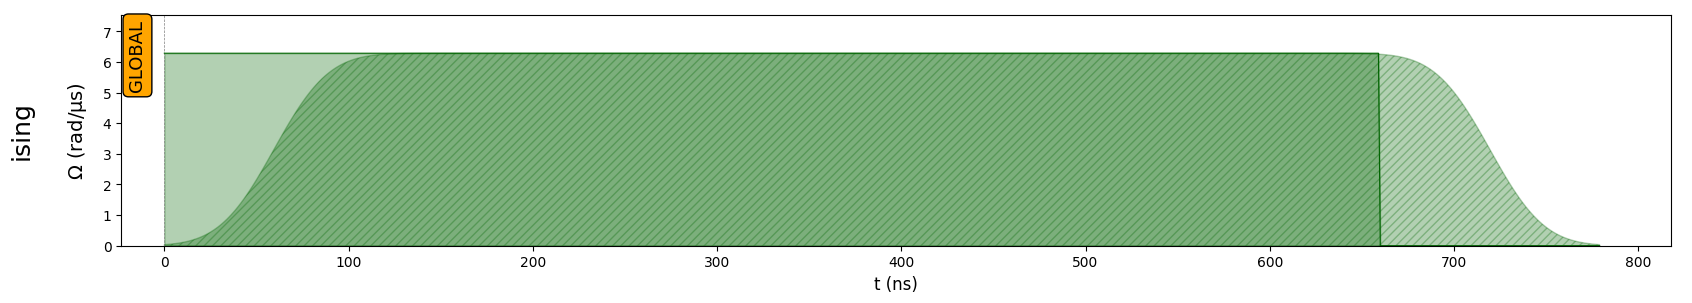

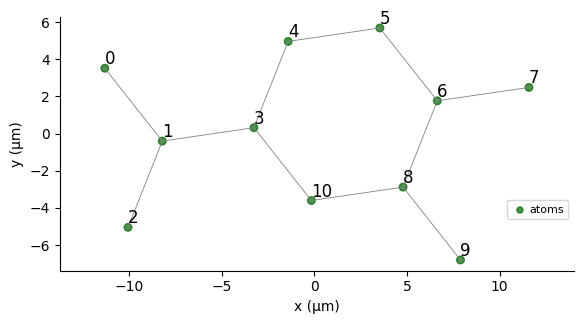

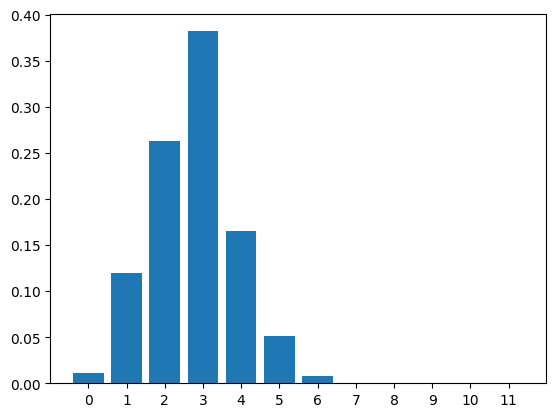

In [184]:
dataset_example = X[64]
dataset_example.draw_sequence()
dataset_example.draw_register()
dataset_example.draw_excitation()

## 2. Quantum Evolution Kernel

The Quantum Evolution Kernel computes a similarity score between two graphs based on quantum-inspired measures. It is designed to work with graph-structured data.

- *A **kernel** is a function that computes a similarity measure between two data points. In ML, kernels are often used to implicitly map data into a higher-dimensional space without computing the transformation explicitly. This enables algorithms like Support Vector Machines (SVM) to solve problems that are not linearly separable in the original feature space.*


### Introducing the Quantum Evolution Kernel

For a graph $G$, let's call the excitation distribution $P_G$.

We may now construct the Quantum Evolution Kernel, or QEK. Mathematically, QEK defined as:
$$
K(G, G') = \exp \left( -\mu JS(P_G, P_{G'}) \right)
$$


where $\mu$ is an hyperparameter of our kernel and $JS$ is the Jensen-Shannon distance.
    

In [185]:
from qek.kernel import QuantumEvolutionKernel as QEK

# Initialize the Quantum Evolution Kernel with a parameter mu
kernel = QEK(mu=0.5)

### `Fit` and `Transform` graph datasets using `QEK`

To use the kernel in machine learning algorithms, we can fit the kernel on a training dataset, and use it to transform training/testing datasets. The result of such a transformation is a kernel matrix, which represents the similarities of graphs. 

In [186]:
# Fit
kernel.fit(X_train)

# Transform
K_train = kernel.transform(X_train)
K_test = kernel.transform(X_test)

print(f"Training Kernel Matrix Shape: {K_train.shape}")
print(f"Testing Kernel Matrix Shape: {K_test.shape}")

Training Kernel Matrix Shape: (223, 223)
Testing Kernel Matrix Shape: (56, 223)


The kernel matrix for the testing dataset looks like:

In [187]:
K_train

array([[1.        , 0.93051453, 0.84982929, ..., 0.87518824, 0.84227677,
        0.78327268],
       [0.93051453, 1.        , 0.95171697, ..., 0.96514616, 0.93813683,
        0.87256124],
       [0.84982929, 0.95171697, 1.        , ..., 0.94978791, 0.94922164,
        0.95506836],
       ...,
       [0.87518824, 0.96514616, 0.94978791, ..., 1.        , 0.99034745,
        0.87734572],
       [0.84227677, 0.93813683, 0.94922164, ..., 0.99034745, 1.        ,
        0.87424501],
       [0.78327268, 0.87256124, 0.95506836, ..., 0.87734572, 0.87424501,
        1.        ]])

Parameter $\mu$ controls the rate of exponential decay. A large value of $\mu$ makes QEK very sensitive to small variations of the Jensen-Shanon distance. Conversely, when $\mu$ is small, the kernel is less affected by small variations in of $JS$.


QEK compares two processed graphs by their distribution of excitations. If `a` and `b` are two graphs, a value of `kernel(a, b)` close to 1 indicates a big similarity between graphs `a` and `b`, while a value close to 0 means a small graph similarity.

Let's try that:

In [189]:
graph_1 = processed_dataset[2]
graph_2 = processed_dataset[0]

display(f"Comparing a graph with itself: {kernel.similarity(graph_1, graph_1)}")
display(f"Comparing two much non similar graphs: {kernel.similarity(graph_1, graph_2)}")

'Comparing a graph with itself: 1.0'

'Comparing two much non similar graphs: 0.7835581001861575'

We can further validate this by checking that the two graphs are registered differently and have different excitations.

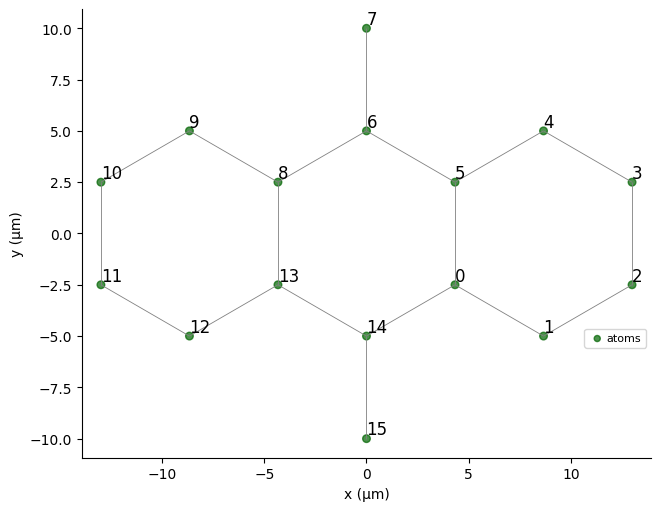

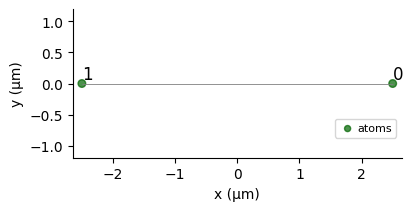

In [190]:
graph_1.draw_register()
graph_2.draw_register()

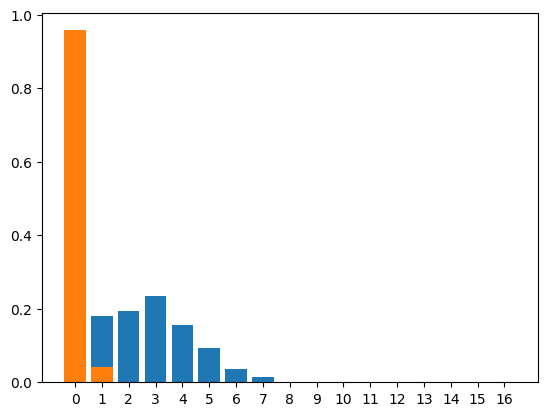

In [191]:
graph_1.draw_excitation()
graph_2.draw_excitation()

## 3. Training a simple model 


The next step is to use the results of the Quantum Device execution on a classical device (i.e. your computer) to create a Quantum Evolution Kernel. Since our algorithm combines steps that are executed on a Quantum Device and steps that are executed on a classical device, we call this a _hybrid algorithm_.

We will use an SVM (Support Vector Machine) to learn how to predict the toxicity of a molecule based on the precomputed kernel. 

In [192]:
from sklearn.svm import SVC
from qek.kernel import QuantumEvolutionKernel as QEK

# Define a SVC model with QuantumEvolutionKernel
qek_kernel = QEK(mu=0.5)
model = SVC(kernel=qek_kernel, random_state=42)

### Training

This precomputed kernel will allow us to evaluate the algorithm QEK. 

In [193]:
model.fit(X_train, y_train)

SVC(kernel=<qek.kernel.kernel.QuantumEvolutionKernel object at 0x3258877f0>,
    random_state=42)

### Evaluation 

We are using the following metrics:
- The F1 score is a way to measure how well a model performs, especially when the data is uneven (e.g., more examples of one category than another). It combines two important aspects: how precise the model is (how many of the predicted positives are actually positive) and how well it captures all the actual positives (recall). It provides a single number that balances these two aspects, making it useful for evaluating performance in real-world scenarios where some categories are much more common than others.

- Balanced accuracy is a method to evaluate a model's performance fairly, even when the data is imbalanced (e.g., one category is much more frequent than others). Instead of just looking at overall accuracy, which can be misleading in such cases, balanced accuracy considers how well the model performs for each category separately and then averages these performances. This ensures that the evaluation is not skewed by the more common categories, giving a more honest picture of the model's effectiveness across all categories.


In [194]:
from sklearn.metrics import accuracy_score, classification_report, f1_score, balanced_accuracy_score
import numpy as np

def evaluate_predictions(y_test, y_pred):
    """
    Evaluates the model predictions using multiple metrics: F1 score, and
    balanced accuracy. Prints the classification report 
    and other evaluation results.

    Args:
        y_test (array-like): The true labels.
        y_pred (array-like): The predicted labels.
    """
    # Calculate F1 score and balanced accuracy
    max_f1_score = f1_score(y_test, y_pred, average='weighted')
    final_f1_std = np.std(f1_score(y_test, y_pred, average=None))
    max_bal_acc = balanced_accuracy_score(y_test, y_pred)
    std_bal_acc = np.std(balanced_accuracy_score(y_test, y_pred))

    # Print the evaluation results
    print("\nEvaluation Results:")
    print(f"F1 Score: {max_f1_score:.2f}")
    print(f"Standard Deviation of F1 Score: {final_f1_std:.2f}")
    print(f"Balanced Accuracy: {max_bal_acc:.2f}")
    print(f"Standard Deviation of Balanced Accuracy: {std_bal_acc:.2f}")

    # Print classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))


We can use the trained model to make predictions on the test dataset

In [195]:
# Making predictions using the trained model
y_pred = model.predict(X_test)

evaluate_predictions(y_test, y_pred)


Evaluation Results:
F1 Score: 0.58
Standard Deviation of F1 Score: 0.16
Balanced Accuracy: 0.56
Standard Deviation of Balanced Accuracy: 0.00
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.82      0.71        33
           1       0.54      0.30      0.39        23

    accuracy                           0.61        56
   macro avg       0.58      0.56      0.55        56
weighted avg       0.59      0.61      0.58        56



## 4. Creating a Pipeline with SVM

Pipelines in scikit-learn allow us to streamline the workflow by chaining preprocessing steps and models. In this step, we integrate the Quantum Evolution Kernel with an SVM classifier in a pipeline for end-to-end model training and prediction.

In [291]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from qek.kernel import QuantumEvolutionKernel as QEK

# Define the pipeline
pipeline = Pipeline([
    ('QEK', QEK(mu=0.5)),
    ('svm', SVC(kernel='precomputed', random_state=42))
])

In [292]:
# Train the pipeline
pipeline.fit(X_train, y_train)

Pipeline(steps=[('QEK',
                 <qek.kernel.kernel.QuantumEvolutionKernel object at 0x3121838e0>),
                ('svm', SVC(kernel='precomputed', random_state=42))])

In [293]:
# Making predictions using the trained model
y_pred = pipeline.predict(X_test)

evaluate_predictions(y_test, y_pred)


Evaluation Results:
F1 Score: 0.58
Standard Deviation of F1 Score: 0.16
Balanced Accuracy: 0.56
Standard Deviation of Balanced Accuracy: 0.00
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.82      0.71        33
           1       0.54      0.30      0.39        23

    accuracy                           0.61        56
   macro avg       0.58      0.56      0.55        56
weighted avg       0.59      0.61      0.58        56



## 5. GridSearchCV for Hyperparameter Optimization


Hyperparameter tuning is a critical step in improving machine learning model performance. **GridSearchCV** systematically searches through a predefined set of hyperparameters to find the combination that yields the best results. Here, we optimize:

- `mu`: A parameter of the Quantum Evolution Kernel.
- `C`: The regularization parameter of the SVM.

We will use the pipeline defined in the previous section inside the grid search. Additionally, we employ multiple scoring metrics such as F1 Score and Balanced Accuracy to evaluate the performance of the models comprehensively.
    

In [294]:
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import make_scorer, f1_score, balanced_accuracy_score
import numpy as np
import matplotlib.pyplot as plt

In [297]:
# Define scoring metrics
scoring = {
    "balanced_accuracy": make_scorer(balanced_accuracy_score),
    "f1_score": make_scorer(f1_score, average="weighted")
}

# Define cross-validation strategy
skf = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)

# Define parameter grid
param_grid = {
    'svm__C': np.logspace(0.001, 1, 10),
    'QEK__mu': [0.25, 0.5, 0.75],
}

grid_search = GridSearchCV(pipeline, param_grid, scoring=scoring, cv=skf, refit="f1_score", n_jobs=8, return_train_score=True)

In [298]:
# Perform grid search
grid_search.fit(X_train, y_train)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=5, random_state=42),
             estimator=Pipeline(steps=[('QEK',
                                        <qek.kernel.kernel.QuantumEvolutionKernel object at 0x3121838e0>),
                                       ('svm',
                                        SVC(kernel='precomputed',
                                            random_state=42))]),
             n_jobs=8,
             param_grid={'QEK__mu': [0.25, 0.5, 0.75],
                         'svm__C': array([ 1.00230524,  1.29419584,  1.67109061,  2.15774441,  2.78612117,
        3.59749335,  4.64515275,  5.99791076,  7.74461798, 10.        ])},
             refit='f1_score', return_train_score=True,
             scoring={'balanced_accuracy': make_scorer(balanced_accuracy_score, response_method='predict'),
                      'f1_score': make_scorer(f1_score, response_method='predict', average=weighted)})

### Evaluation  

We can access best trained model from the grid search using *.best_estimator_*.

In [303]:
# Evaluate the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

evaluate_predictions(y_test, y_pred)


Evaluation Results:
F1 Score: 0.59
Standard Deviation of F1 Score: 0.12
Balanced Accuracy: 0.57
Standard Deviation of Balanced Accuracy: 0.00
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.76      0.69        33
           1       0.53      0.39      0.45        23

    accuracy                           0.61        56
   macro avg       0.59      0.57      0.57        56
weighted avg       0.60      0.61      0.59        56



We can also access the results of grid search using *.cv_results_*. This allows us to plot learning curves, as well as see the impact of different hyperparamters on model performance. 

In [304]:
# Extract results
cv_results = grid_search.cv_results_

# Simple plot function to plot results
import matplotlib.pyplot as plt
import numpy as np

def plot_grid_search_results(grid_search, param_name="svm__C"):
    cv_results = grid_search.cv_results_
    param_values = [p[param_name] for p in cv_results['params']]
    unique_param_values = sorted(set(param_values))

    mean_f1_scores = []
    std_f1_scores = []

    for param_value in unique_param_values:
        indices = [i for i, p in enumerate(cv_results['params']) if p[param_name] == param_value]
        mean_f1_scores.append(np.mean([cv_results['mean_test_f1_score'][i] for i in indices]))
        std_f1_scores.append(np.mean([cv_results['std_test_f1_score'][i] for i in indices]))

    plt.figure(figsize=(6, 5))
    plt.plot(unique_param_values, mean_f1_scores, label="Mean F1 Score")
    plt.fill_between(unique_param_values, 
                     np.array(mean_f1_scores) - np.array(std_f1_scores),
                     np.array(mean_f1_scores) + np.array(std_f1_scores), 
                     alpha=0.2)
    
    plt.title(f"Grid Search Results for {param_name}")
    plt.xlabel(f"{param_name}")
    plt.ylabel("Mean F1 Score")
    plt.legend()
    plt.grid(True)
    plt.show()

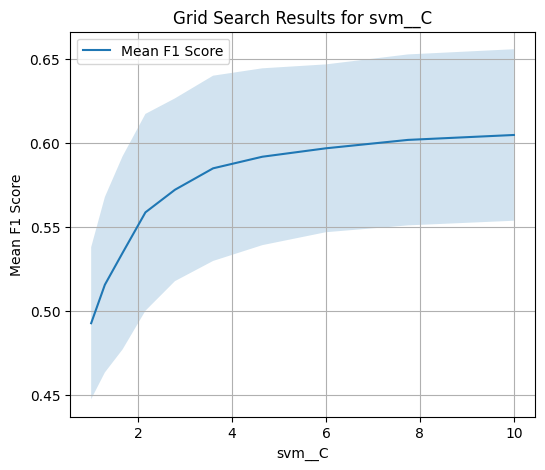

In [305]:
plot_grid_search_results(grid_search, 'svm__C')

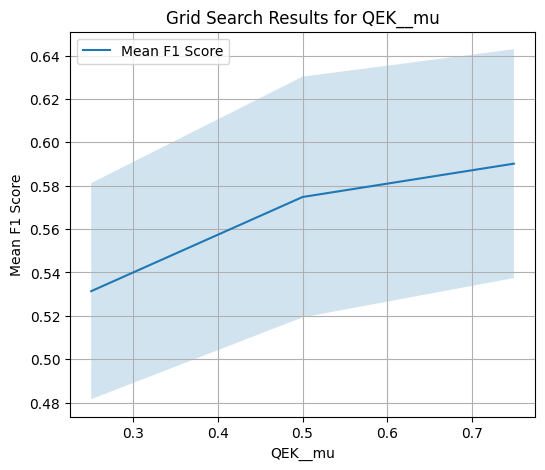

In [306]:
plot_grid_search_results(grid_search, 'QEK__mu')